# Задача 1 
Посчитать численно $DV01$ как разностную производную.
1. Номер выпуска облигации определяет функция getBond ниже
1. Процентные ставки известны ниже curve_tenors, curve_rates
1. Использоватье линейную интерполяцию кубическими сплайнами (см. пример ниже)


Данные о выпуске облигаций доступны по ссылке 
https://www.efd.admin.ch/efd/en/home/the-fdf/nsb-news_list.msg-id-85031.html

$$ PV  = PV (r_1, r_2, r_3, ..., r_N) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i)^{t_i}} $$
где $r_i$ - значение ставки, $C_i$ - выплата в день купонного платежа под номером $i$

$$ DV01 (r_1, r_2,  ..., r_N) = \lim \limits_{\delta \to 0} \frac{PV (r_1 + \delta r, r_2 + \delta r, ..., r_N + \delta r) - PV (r_1, r_2,  ..., r_N)}{\delta}  \approx
\frac{PV (r_1 + \Delta r, r_2 + \Delta r, ..., r_N + \Delta r) - PV (r_1 - \Delta r, r_2 - \Delta r, ..., r_N - \Delta r)}{2 \Delta r}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

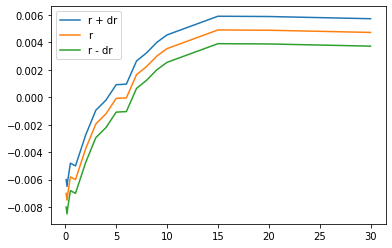

In [3]:
from matplotlib.pyplot import plot, legend

curve_tenors = np.array([1/12, 1/6, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0])
curve_rates = np.array([-0.700, -0.750, -0.700, -0.580, -0.600, -0.375, -0.194, -0.120, -0.008, -0.004, 0.165, 0.225, 0.301, 0.355, 0.491, 0.489, 0.473])*1e-2

plot(curve_tenors, curve_rates + 1e-3, label = 'r + dr');
plot(curve_tenors, curve_rates, label = 'r');
plot(curve_tenors, curve_rates - 1e-3, label = 'r - dr');
legend();

In [4]:
def getBond(email):
    import hashlib
    h = int(hashlib.sha1(email.encode('utf-8')).hexdigest(), 16)
    bonds = ['CH0184249990', 'CH0344958688', 'CH0344958498']
    return bonds[h % len(bonds)]
getBond('lozovoy.hse@gmail.com')

'CH0344958498'

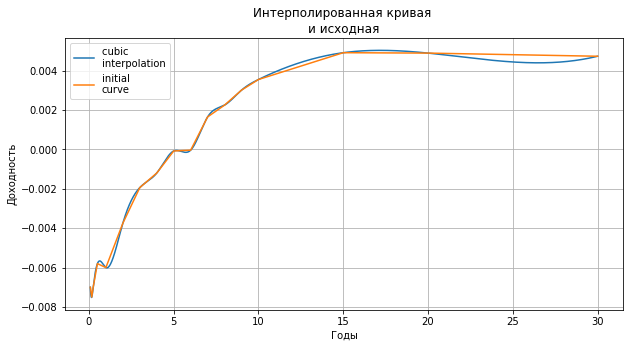

In [21]:
import numpy as np
import scipy.interpolate

f = scipy.interpolate.interp1d(curve_tenors, curve_rates, kind = 'cubic')
# нарисуем интерполированные кривые для годовых данных
# возьмем дневной шаг - это пригодится нам для дисконтирования любого бонда
new_tenors = np.arange(curve_tenors[0], curve_tenors[-1], 1/360)
interpolated = f(new_tenors) 

plt.figure(figsize=(10, 5));
plt.plot(new_tenors, interpolated, label = 'cubic \ninterpolation');
plt.plot(curve_tenors, curve_rates, label = 'initial \ncurve');
plt.legend();
plt.grid();
plt.title('Интерполированная кривая \nи исходная');
plt.xlabel('Годы');
plt.ylabel('Доходность');

Здесь я перечислю основные параметры по моей облигации, которые мне удалось найти и которые я использовал в расчетах:
* Текущая цена 93.92
* Купон платится ежегодно, 0.5% p. a.
* day convention 360 days in year
* Дата выпуска 28.06.2017
* Дата ближайшего купона 28.06.2022
* Дата погашения 27.06.2045

Как я понимаю, от нас требуется продисконтировать купоны и номинал по ставкам из кривой (а иначе зачем бы нам ее дали?)

In [22]:
c_days = pd.to_datetime('28.06.2022') - pd.to_datetime('31-03-2022')
print(f"До ближайшего купона осталось {c_days} дней.")

До ближайшего купона осталось 89 days 00:00:00 дней.


In [39]:
days = [89, *[360 for _ in range(23)]]
cumulative_days = np.cumsum(days)
# по номерам дней получим ставки дисконтирования из кривой
indexes = [x-1 for x in cumulative_days]
rates = interpolated[indexes]
# получим дисконт-факторы
dfs = (1+np.array(rates))**(cumulative_days/360)
# зададим платежи
cf = np.array([5 * 89/360, *[5 for _ in range(len(days)-2)], 1005])
# проверим что длина массива с платежами совпадает с длиной массива дат
assert len(cf) == len(days)
# посчитаем цену с помощью кривой
pv = np.sum(cf/dfs)
print(f"Рыночная цена бонда при дисконтировании по данной кривой: {pv}")

Рыночная цена бонда при дисконтировании по данной кривой: 1010.2439126240986


In [46]:
# теперь посчитаем DV01 тем методом, что предложили нам выше
# для этого напишем функцию, которая считает цену бонда по заданной кривой 
# и заданному массиву платежей
from typing import Union

def bond_price(rates:Union[np.array, list],
               days:Union[np.array, list],
               payments: Union[np.array, list],
               days_in_year: int = 360
               ) -> float:
    """Returns bond price from given yield curve, days to
    each payment and cash flows"""
    cumulative_days = np.cumsum(days)
    indexes = [x-1 for x in cumulative_days]
    dfs = (1+np.array(rates))**(cumulative_days/days_in_year)
    pv = np.sum(payments/dfs)
    return pv
    
# посчитаем две цены бонда: когда из кривой вычли 1e-4 и добавили 1e-4
# если я правильно помню, DV01 считается для 1 базисного пункта
# а это значит, что мы должны использовать именно 1e-4
p1 = bond_price(rates -(1e-4), days, cf)
p2 = bond_price(rates +(1e-4), days, cf)
dv01 = (p1 - p2)/2
print(f"DV01: {dv01}")

DV01: 2.212295803804011


# Задача 2

1. Взяв облигацию из предыдущей задачи, захэджировать ее  CH0557778310

https://www.efd.admin.ch/efd/en/home/the-fdf/nsb-news_list.msg-id-87527.html


Использовать для расчета $DV01$ кривую выше

Чему равна $beta$?



2. Построить график $PV$ портфеля от величины вертикального сдвига кривой $\Delta$
$$ PV (r; \Delta) = PV (r_1 + \Delta, r_2+ \Delta, r_3+ \Delta, ..., r_N+ \Delta) = \sum \limits_{i=1}^{N} \frac{C_i}{(1 + r_i + \Delta)^{t_i}} $$



